In [1]:
import pandas as pd
import re
import datetime

orign_df = pd.read_csv('../combined_zillow.csv')

In [2]:
orign_df.head(5)

,title,price,bds,ba,sqft,time on zillow,veiws,saves,agent,type,parking,buit,history,HOA,schools,neighborhood_home,zillow_prediction,Zillow,city
0,"428 Silk Tree, Irvine, CA 92606","$565,000",2 bds,2 ba,"1,261 sqft",,,,,,,,,,,,,555733,irvine
1,"47 Spanish Lace, Irvine, CA 92620","$585,000",2 bds,2 ba,"1,279 sqft",77,"3,647",79,Brian Barbour Berkshire Hathaway HomeService,Condo,2 spaces,2006,DATE\tEVENT\tPRICE 12/4/2019\tPrice change\t$5...,$125/mo,8/10 Woodbury Elementary School Grades:K-6 Dis...,Woodbury home values have fallen 0.4 % over th...,Zillow predicts the home values in Woodbury wi...,580856,irvine
2,"213 Carmine, Irvine, CA 92618","$750,000",3 bds,3 ba,"1,619 sqft",90,"10,556",259,Ronnie And Cyrena Berkshire Hathaway HomeService,Single Family,2 spaces,2018,DATE\tEVENT\tPRICE 12/3/2019\tPrice change\t$7...,$216/mo,8/10 Beacon Park Grades:K-8 Distance:0.5 mi NA...,92618 home values have fallen 0.4 % over the p...,Zillow predicts the home values in Orange Coun...,741157,irvine
3,"8 Deodar St, Irvine, CA 92604","$728,800",4 bds,3 ba,"1,642 sqft",82,"13,793",357,Mana Aminian First Team Real Estate,Single Family,2 spaces,1976,DATE\tEVENT\tPRICE 11/13/2019\tPrice change\t$...,$335/mo,8/10 Deerfield Elementary School Grades:K-6 Di...,El Camino Real home values have fallen 0.4 % o...,Zillow predicts the home values in El Camino R...,724958,irvine
4,"137 Silverado, Irvine, CA 92618","$685,000",3 bds,3 ba,"1,756 sqft",165,"5,363",142,Kenneth Chao Coldwell Banker George Realty,Condo,2 spaces,2010,,$134/mo,9/10 Portola Springs Elementary Grades:K-6 Dis...,Portola Springs home values have fallen 0.4 % ...,Zillow predicts the home values in Portola Spr...,671833,irvine


In [4]:
orign_df.shape

(1959, 19)

In [5]:
orign_df.columns

Index(['title', 'price', 'bds', 'ba', 'sqft', 'time on zillow', 'veiws',
       'saves', 'agent', 'type', 'parking', 'buit', 'history', 'HOA',
       'schools', 'neighborhood_home', 'zillow_prediction', 'Zillow', 'city'],
      dtype='object')

In [3]:
orign_df["zillow_prediction"][1]

'Zillow predicts the home values in Woodbury will fall 0.1% in the next year.'

In [4]:
orign_df["history"][0]

' '

In [5]:
df = orign_df.copy()

In [6]:
df['zipcode'] = df['title'].str[-5:]

In [7]:
# to create neighbor are column
def get_area(row):
    i = row.find("home")
    return row[:i]
df["area"]= df['neighborhood_home'].apply(get_area)

df["area"].value_counts()

92618                256
92602                 77
92612                 74
90301                 49
90302                 46
                    ... 
Beverlywood            1
Pico-Robertson         1
Harbor Gateway         1
Bel Air                1
University Hills       1
Name: area, Length: 125, dtype: int64

In [8]:
df["prediction"] = df["zillow_prediction"].str.split().str[-6]
df["prediction"].value_counts()

increase    637
rise        627
fall        359
decrease    304
Name: prediction, dtype: int64

In [9]:
df["prediction_rate"] = df["zillow_prediction"].str.split().str[-5]
df.drop("zillow_prediction", axis = 1, inplace = True)
df["prediction_rate"].value_counts()


0.8%    260
0%       92
4.5%     92
1.6%     80
0.6%     71
       ... 
6%        2
8.5%      2
5.4%      2
6.3%      1
9.8%      1
Name: prediction_rate, Length: 71, dtype: int64

In [10]:
def combine_prediction(row):
    if row == 'rise':
        return "increase"
    elif row == "fall":
        return "decrease"
    else:
        return row

In [11]:
df["prediction_combined"] = df["prediction"].apply(combine_prediction) 
df["prediction_combined"].value_counts()

increase    1264
decrease     663
Name: prediction_combined, dtype: int64

In [12]:
def try_float(x):
    try:
        float(x)
        return True
    except:
        return False

In [13]:
df = df.loc[~df.history.apply(try_float)]

In [14]:
df = df.loc[~df.schools.apply(try_float)]

In [15]:
def school_list(row):
    school_list =[]
    if row == "":
        return None
    else:
        for i, v in enumerate(row.split(':')[::2][:3]):
            ind = v.find('/')
            if i == 0:
                result = [v[:ind], v[ind+3:]]
            else:
                if len(v) > 6:
                    result = [v[ind-1], v[ind+3:]]
                else:
                    result = 'None'
            school_list.append(result)
    return school_list

In [16]:
df["school_list"] = df["schools"].apply(school_list) 
df["school_list"]

0                                                  [[, ]]
1       [[8,  Woodbury Elementary School Grades], [0, ...
2       [[8,  Beacon Park Grades], [e, 5 mi NA Portola...
3       [[8,  Deerfield Elementary School Grades], [8,...
4       [[9,  Portola Springs Elementary Grades], [0, ...
                              ...                        
1954    [[3,  Highland Elementary School Grades], [1, ...
1955    [[2,  Payne (Beulah) Elementary School Grades]...
1956    [[1,  Lane (Warren) Elementary School Grades],...
1957    [[1,  Lane (Warren) Elementary School Grades],...
1958    [[4,  La Tijera School Grades], [1,  Inglewood...
Name: school_list, Length: 1658, dtype: object

In [17]:
def history_convert(row):
    clean_row = row[17:-1].split('\t')
    history_status = [v.strip() for v in clean_row[1::3]]
    history_date = []
    for v in clean_row[::3]:
        if v != '':
            result = datetime.datetime.strptime(v.strip(), '%m/%d/%Y')
            history_date.append(result.date())
        
    history_price = []
    for v in clean_row[2::3]:
        ind = v.find("(")
        if ind > 0:
            result = v[:ind].replace("$", "").replace(",","")
        else:
            result = v.replace("$","").replace(",","")
        history_price.append(float(result))
    
    return (history_date, history_status, history_price)

In [18]:
df["history_date"] = df["history"].apply(lambda row:history_convert(row)[0])
df["history_status"] = df["history"].apply(lambda row:history_convert(row)[1])
df["history_price"]= df["history"].apply(lambda row:history_convert(row)[2])



In [19]:
df["history_date"] 

0                                                      []
1                    [2019-12-04, 2019-10-23, 2006-05-26]
2                                [2019-12-03, 2019-10-10]
3       [2019-11-13, 2019-10-18, 2019-06-06, 2007-08-1...
4                                                      []
                              ...                        
1954                                         [2019-12-04]
1955    [2020-01-08, 2019-12-11, 2019-12-06, 2019-11-2...
1956                 [2006-09-22, 2004-05-14, 2002-12-09]
1957                                         [1999-07-28]
1958    [2009-09-10, 2009-06-13, 2009-04-04, 2008-07-1...
Name: history_date, Length: 1658, dtype: object

In [20]:
df["history_status"]

0                                                      []
1                   [Price change, Listed for sale, Sold]
2                         [Price change, Listed for sale]
3       [Price change, Listed for sale, Sold, Sold, Sold]
4                                                      []
                              ...                        
1954                                    [Listed for sale]
1955    [Back on market, Pending sale, Price change, P...
1956                                   [Sold, Sold, Sold]
1957                                               [Sold]
1958    [Sold, Price change, Listed for sale, Sold, Sold]
Name: history_status, Length: 1658, dtype: object

In [21]:
df["history_price"]

0                                                      []
1                          [585000.0, 600000.0, 518000.0]
2                                    [750000.0, 775000.0]
3       [728800.0, 738800.0, 595500.0, 550000.0, 40500...
4                                                      []
                              ...                        
1954                                           [810000.0]
1955    [509900.0, 509900.0, 509900.0, 514000.0, 50990...
1956                       [580000.0, 399000.0, 170000.0]
1957                                           [175000.0]
1958    [427000.0, 419900.0, 449900.0, 600000.0, 23500...
Name: history_price, Length: 1658, dtype: object

In [22]:
new_df = df.copy()

In [23]:
new_df = new_df.drop(["history","schools","neighborhood_home"], axis = 1)
print(new_df.shape)
new_df.head(5)

(1658, 24)


,title,price,bds,ba,sqft,time on zillow,veiws,saves,agent,type,...,city,zipcode,area,prediction,prediction_rate,prediction_combined,school_list,history_date,history_status,history_price
0,"428 Silk Tree, Irvine, CA 92606","$565,000",2 bds,2 ba,"1,261 sqft",,,,,,...,irvine,92606,,NaN,NaN,NaN,"[[, ]]",[],[],[]
1,"47 Spanish Lace, Irvine, CA 92620","$585,000",2 bds,2 ba,"1,279 sqft",77,"3,647",79,Brian Barbour Berkshire Hathaway HomeService,Condo,...,irvine,92620,Woodbury,fall,0.1%,decrease,"[[8, Woodbury Elementary School Grades], [0, ...","[2019-12-04, 2019-10-23, 2006-05-26]","[Price change, Listed for sale, Sold]","[585000.0, 600000.0, 518000.0]"
2,"213 Carmine, Irvine, CA 92618","$750,000",3 bds,3 ba,"1,619 sqft",90,"10,556",259,Ronnie And Cyrena Berkshire Hathaway HomeService,Single Family,...,irvine,92618,92618,fall,0.8%,decrease,"[[8, Beacon Park Grades], [e, 5 mi NA Portola...","[2019-12-03, 2019-10-10]","[Price change, Listed for sale]","[750000.0, 775000.0]"
3,"8 Deodar St, Irvine, CA 92604","$728,800",4 bds,3 ba,"1,642 sqft",82,"13,793",357,Mana Aminian First Team Real Estate,Single Family,...,irvine,92604,El Camino Real,rise,0.5%,increase,"[[8, Deerfield Elementary School Grades], [8,...","[2019-11-13, 2019-10-18, 2019-06-06, 2007-08-1...","[Price change, Listed for sale, Sold, Sold, Sold]","[728800.0, 738800.0, 595500.0, 550000.0, 40500..."
4,"137 Silverado, Irvine, CA 92618","$685,000",3 bds,3 ba,"1,756 sqft",165,"5,363",142,Kenneth Chao Coldwell Banker George Realty,Condo,...,irvine,92618,Portola Springs,decrease,0.6%,decrease,"[[9, Portola Springs Elementary Grades], [0, ...",[],[],[]


In [24]:
# after excluding the studio, and lot records and then convert the rest of records from string to float data type 
new_df = new_df[(new_df["bds"] != "Studio") & (new_df["bds"].str.split().str[-1] != 'lot')]
new_df["bds"] = new_df["bds"].str.split().str[0].astype('int')
print(new_df.shape)
new_df["bds"].unique()


(1605, 24)


array([ 2,  3,  4,  7,  5,  6,  1,  8, 10, 17, 14, 12,  9, 15, 13, 11, 40])

In [25]:
# same as the baths
new_df = new_df[new_df["ba"] !='#NAME?']
new_df["ba"] = new_df["ba"].str.split().str[0].astype('float')
print(new_df.shape)
new_df["ba"].unique()



(1601, 24)


array([ 2. ,  3. , 11. ,  5. ,  4. ,  2.5,  9. ,  1. ,  6. ,  8. , 13. ,
        7. , 10. ,  1.5,  3.5,  4.5,  5.5,  nan, 40. ])

In [26]:
new_df["sqft"].value_counts(ascending = True)

870 sqft        1
1,318 sqft      1
1,477 sqft      1
6,306 sqft      1
2,905 sqft      1
             ... 
1 bd           20
5 bds          22
4 bds          44
2 bds          91
3 bds         101
Name: sqft, Length: 978, dtype: int64

In [27]:
# finding weird data of sqft column
def convert_sqft(row):
    result = row.split(" ")
    if result[-1] == 'sqft':
        return float(result[0].replace(",",""))
    else:
        return 0


In [28]:
new_df["sqft_num"] = new_df["sqft"].apply(convert_sqft)
new_df["sqft_num"].value_counts()

0.0       305
1204.0      8
1300.0      6
1800.0      5
1440.0      5
         ... 
3703.0      1
1947.0      1
1418.0      1
4906.0      1
1756.0      1
Name: sqft_num, Length: 964, dtype: int64

In [29]:
new_df["time on zillow"] = new_df["time on zillow"].str[:-4]

In [30]:
new_df["prediction_rate"] = new_df["prediction_rate"].str.replace("%","").astype('float')

In [31]:
new_df["prediction_rate"].value_counts()

0.8    90
4.5    87
1.4    59
0.6    59
2.1    57
       ..
6.0     2
5.4     2
8.2     2
9.8     1
6.3     1
Name: prediction_rate, Length: 71, dtype: int64

In [32]:
import numpy as np
new_df["time on zillow"] = pd.to_numeric(new_df["time on zillow"], errors='coerce').fillna(0).astype(np.int64)
new_df["veiws"] = pd.to_numeric(new_df["veiws"], errors='coerce').fillna(0).astype(np.int64)
new_df["saves"] = pd.to_numeric(new_df["saves"], errors='coerce').fillna(0).astype(np.int64)
new_df["Zillow"] = pd.to_numeric(new_df["Zillow"], errors='coerce').fillna(0).astype(np.int64)

In [33]:
new_df.head(5)

,title,price,bds,ba,sqft,time on zillow,veiws,saves,agent,type,...,zipcode,area,prediction,prediction_rate,prediction_combined,school_list,history_date,history_status,history_price,sqft_num
0,"428 Silk Tree, Irvine, CA 92606","$565,000",2,2.0,"1,261 sqft",0,0,0,,,...,92606,,NaN,NaN,NaN,"[[, ]]",[],[],[],1261.0
1,"47 Spanish Lace, Irvine, CA 92620","$585,000",2,2.0,"1,279 sqft",0,0,79,Brian Barbour Berkshire Hathaway HomeService,Condo,...,92620,Woodbury,fall,0.1,decrease,"[[8, Woodbury Elementary School Grades], [0, ...","[2019-12-04, 2019-10-23, 2006-05-26]","[Price change, Listed for sale, Sold]","[585000.0, 600000.0, 518000.0]",1279.0
2,"213 Carmine, Irvine, CA 92618","$750,000",3,3.0,"1,619 sqft",0,0,259,Ronnie And Cyrena Berkshire Hathaway HomeService,Single Family,...,92618,92618,fall,0.8,decrease,"[[8, Beacon Park Grades], [e, 5 mi NA Portola...","[2019-12-03, 2019-10-10]","[Price change, Listed for sale]","[750000.0, 775000.0]",1619.0
3,"8 Deodar St, Irvine, CA 92604","$728,800",4,3.0,"1,642 sqft",0,0,357,Mana Aminian First Team Real Estate,Single Family,...,92604,El Camino Real,rise,0.5,increase,"[[8, Deerfield Elementary School Grades], [8,...","[2019-11-13, 2019-10-18, 2019-06-06, 2007-08-1...","[Price change, Listed for sale, Sold, Sold, Sold]","[728800.0, 738800.0, 595500.0, 550000.0, 40500...",1642.0
4,"137 Silverado, Irvine, CA 92618","$685,000",3,3.0,"1,756 sqft",0,0,142,Kenneth Chao Coldwell Banker George Realty,Condo,...,92618,Portola Springs,decrease,0.6,decrease,"[[9, Portola Springs Elementary Grades], [0, ...",[],[],[],1756.0


In [125]:
new_df["first_school_grade"] = new_df["school_list"].str[0].str[0]
new_df["first_school_grade"] = pd.to_numeric(new_df["first_school_grade"], errors='coerce').fillna(0).astype(np.int64)
new_df["first_school"] = new_df["school_list"].str[0].str[1]
new_df["second_school_grade"] = new_df["school_list"].str[1].str[0]
new_df["second_school"] = new_df["school_list"].str[1].str[1]
new_df["third_school_grade"] = new_df["school_list"].str[2].str[0]
new_df["third_school"] = new_df["school_list"].str[2].str[1]

In [126]:
new_df[["first_school_grade","first_school","second_school_grade","second_school","third_school_grade","third_school"]]

,first_school_grade,first_school,second_school_grade,second_school,third_school_grade,third_school
1,8,Woodbury Elementary School Grades,0,Jeffrey Trail Middle Grades,e,5 mi NA Portola High Grades
2,8,Beacon Park Grades,e,5 mi NA Portola High Grades,N,o
3,8,Deerfield Elementary School Grades,8,Venado Middle School Grades,9,Irvine High School Grades
4,9,Portola Springs Elementary Grades,0,Jeffrey Trail Middle Grades,e,8 mi NA Portola High Grades
5,8,Greentree Elementary School Grades,8,Venado Middle School Grades,9,Irvine High School Grades
...,...,...,...,...,...,...
1954,3,Highland Elementary School Grades,1,Crozier (George W.) Middle School Grades,1,Inglewood High School Grades
1955,2,Payne (Beulah) Elementary School Grades,1,Crozier (George W.) Middle School Grades,3,Morningside High School Grades
1956,1,Lane (Warren) Elementary School Grades,2,Monroe (Albert F.) Middle School Grades,1,Inglewood High School Grades
1957,1,Lane (Warren) Elementary School Grades,2,Monroe (Albert F.) Middle School Grades,1,Morningside High School Grades


In [128]:
first_school_g = new_df.groupby(["city","first_school_grade"]).title.count()
first_school_g_df = first_school_g.reset_index()
first_school_g_df

,city,first_school_grade,title
0,LA,0,6
1,LA,1,28
2,LA,2,99
3,LA,3,90
4,LA,4,126
5,LA,5,99
6,LA,6,64
7,LA,7,61
8,LA,8,105
9,LA,9,47


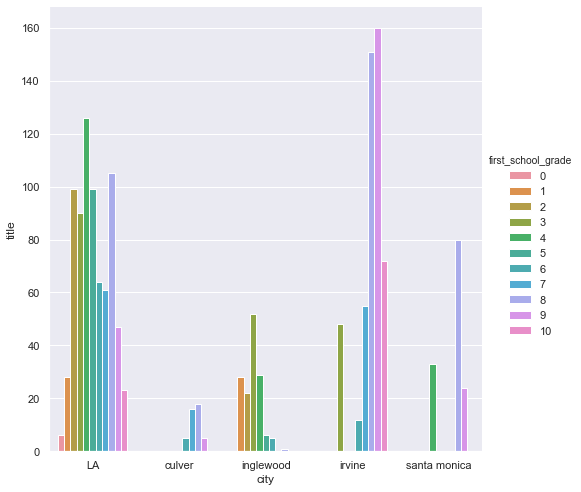

In [142]:
# thrid - home distributed by school district rating 
import seaborn as sns
sns.set(font_scale = 1)
sns.catplot(x='city',y= 'title', hue ='first_school_grade', kind='bar', data=first_school_g_df, height = 7)
plt.rcParams["axes.labelsize"] = 4
plt.show()

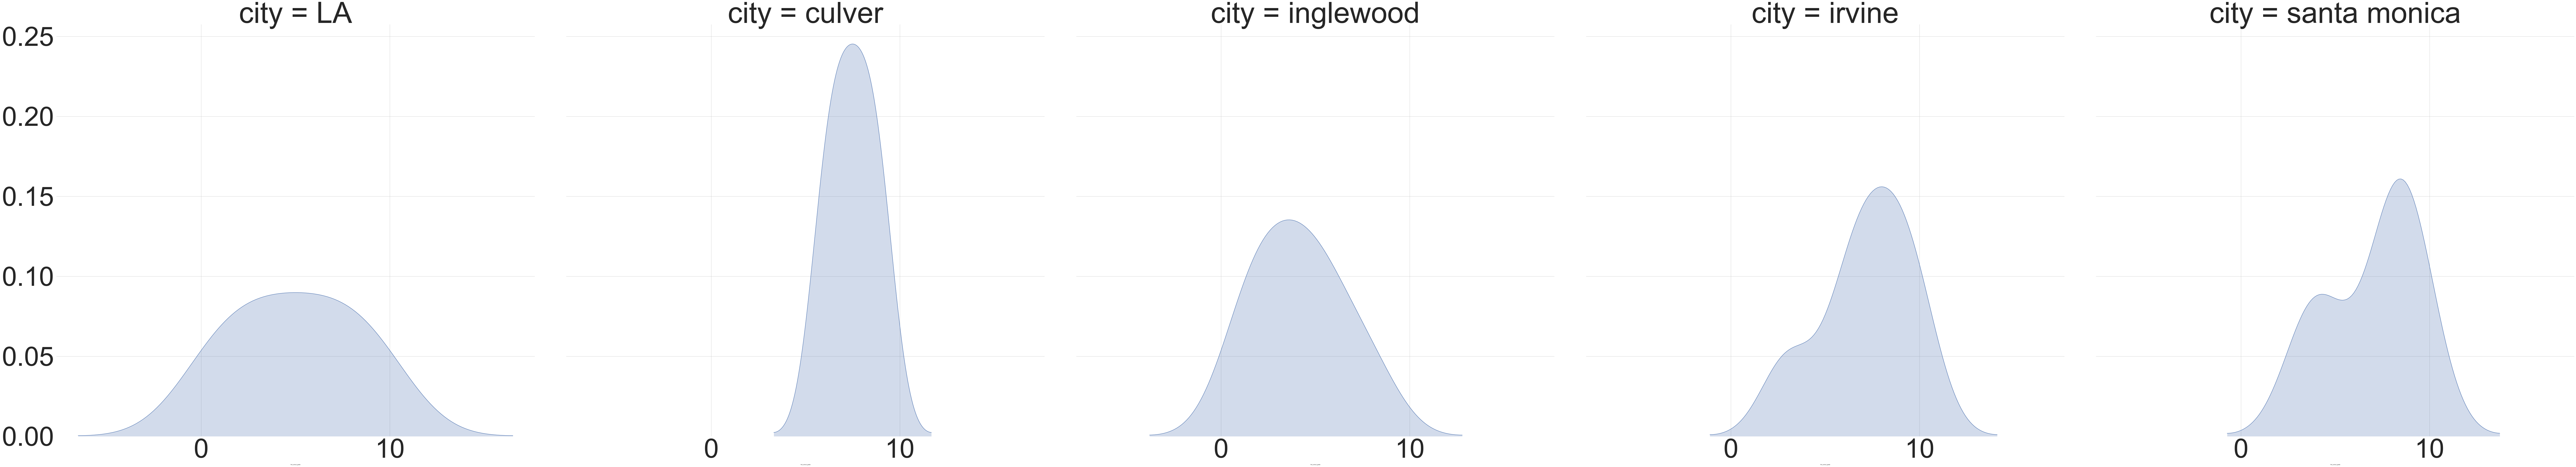

In [130]:
g= sns.FacetGrid(first_school_g_df, col = 'city', size =30)
sns.set(font_scale = 10)
g.map(sns.kdeplot, "first_school_grade", shade = True)
sns.despine(left = True, bottom = True)
sns.set_style("whitegrid")
plt.rcParams["axes.labelsize"] = 5
plt.show()

In [148]:
interest_type = ['Condo','Single Family','Townhouse']
new_df = new_df[new_df['Zillow'] != 0]
city_type_g = new_df.loc[new_df['type'].isin(interest_type)].groupby(['city','type']).Zillow.agg(['count','min','max','mean'])
city_type_g_df = city_type_g.reset_index()
city_type_g_df

,city,type,count,min,max,mean
0,LA,Condo,194,190009,1298740,5.849643e+05
1,LA,Single Family,398,59939,1810247,7.915742e+05
2,LA,Townhouse,62,300001,1103433,5.426185e+05
3,culver,Condo,17,465003,1499008,7.241515e+05
4,culver,Single Family,16,994238,2800018,1.927113e+06
5,culver,Townhouse,4,668781,1492556,1.023239e+06
6,inglewood,Condo,26,305001,813277,5.109563e+05
7,inglewood,Single Family,65,305073,1577694,6.932946e+05
8,inglewood,Townhouse,4,406000,625008,5.152870e+05
9,irvine,Condo,182,318985,2145753,7.846258e+05


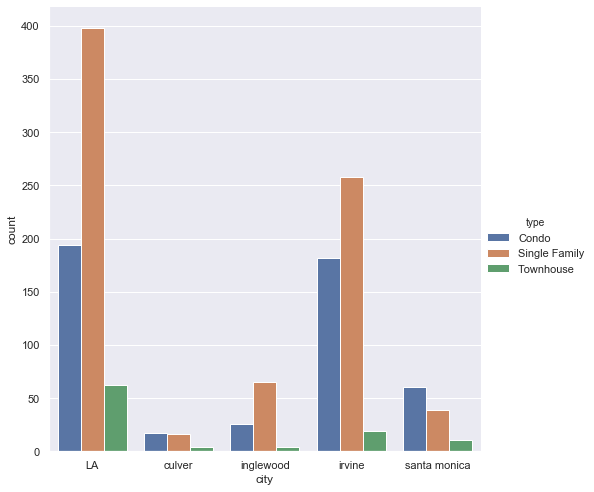

In [149]:
sns.set(font_scale = 1)
sns.catplot(x='city',y= 'count', hue ='type', kind='bar', data=city_type_g_df, height = 7)
plt.rcParams["axes.labelsize"] = 4
plt.show()

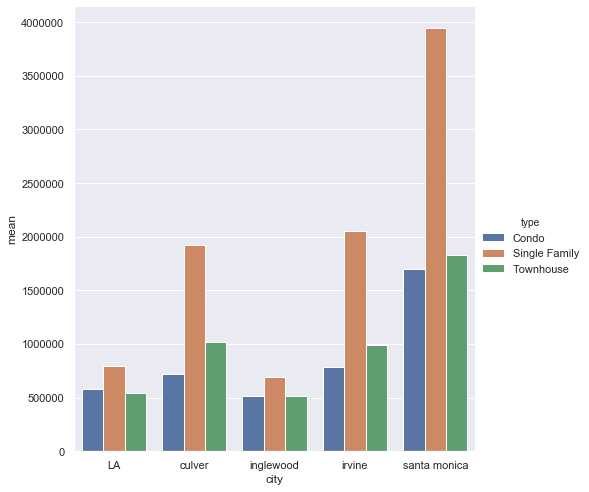

In [150]:
# the first graph
sns.set(font_scale = 1)
sns.catplot(x='city',y= 'mean', hue ='type', kind='bar', data=city_type_g_df, height = 7)
plt.rcParams["axes.labelsize"] = 4
plt.show()

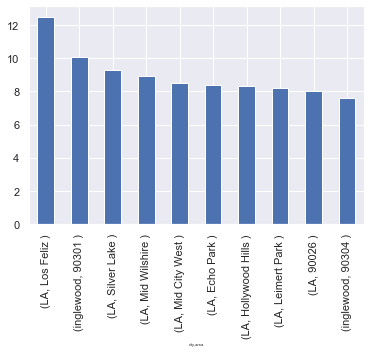

In [166]:
# second one  neighbohood with the highest predicted increase
new_df[new_df['prediction'] =='increase'].groupby(['city','area']).prediction_rate.max().sort_values(ascending = False)[:10].plot.bar()



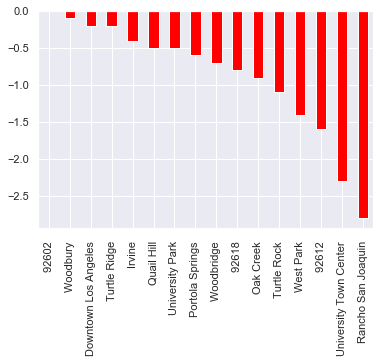

In [181]:
fig, ax = plt.subplots()
decrease_city_area_g = new_df[new_df['prediction'] =='decrease'].groupby(['city','area']).prediction_rate.max().sort_values()
decrease_city_area_g_df = decrease_city_area_g.reset_index()
decrease_city_area_g_df["negative_rate"] = decrease_city_area_g_df["prediction_rate"] * -1
decrease_city_area_g_df["negative_rate"].plot.bar(color='red')

xlabel = [v[1] for v in decrease_city_area_g.index]
ax.set_xticklabels(xlabel)
plt.show()

In [182]:
first_school_zillow_g = new_df.groupby(["city","first_school_grade"]).agg({'title':'count', 'Zillow':'mean'}) 
first_school_zillow_g_df = first_school_zillow_g.reset_index()
first_school_zillow_g_df

,city,first_school_grade,title,Zillow
0,LA,0,6,7.411115e+05
1,LA,1,28,6.298347e+05
2,LA,2,95,6.199739e+05
3,LA,3,86,6.495892e+05
4,LA,4,120,6.014643e+05
5,LA,5,93,7.042539e+05
6,LA,6,64,6.423013e+05
7,LA,7,60,6.860493e+05
8,LA,8,105,7.905362e+05
9,LA,9,46,8.263811e+05


In [183]:
city_value = new_df.groupby(['city','type']).Zillow.mean()
city_value_df = city_value.reset_index()
city_value_df

,city,type,Zillow
0,LA,Condo,5.849643e+05
1,LA,Cooperative,3.043864e+05
2,LA,Mobile / Manufactured,2.009191e+05
3,LA,Multi Family,7.360268e+05
4,LA,Single Family,7.915742e+05
5,LA,Townhouse,5.426185e+05
6,culver,Condo,7.241515e+05
7,culver,Multi Family,1.843525e+06
8,culver,Multiple Occupancy,1.390890e+06
9,culver,Single Family,1.927113e+06


In [184]:
new_df["second_school_grade"].value_counts()

9    237
3    216
7    202
2    201
0    149
8    118
1     96
4     76
5     76
e     62
6     61
N      1
Name: second_school_grade, dtype: int64

In [185]:
new_df[(new_df["second_school_grade"] =="e") | (new_df["second_school_grade"] =="N")].city.value_counts()

irvine    62
LA         1
Name: city, dtype: int64

In [186]:
data = new_df.copy()

In [187]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1501 entries, 1 to 1958
Data columns (total 32 columns):
title                  1501 non-null object
price                  770 non-null object
bds                    1501 non-null int64
ba                     1375 non-null float64
sqft                   1501 non-null object
time on zillow         1501 non-null int64
veiws                  1501 non-null int64
saves                  1501 non-null int64
agent                  1501 non-null object
type                   1501 non-null object
parking                1501 non-null object
buit                   1489 non-null object
HOA                    1501 non-null object
Zillow                 1501 non-null int64
city                   1501 non-null object
zipcode                1501 non-null object
area                   1501 non-null object
prediction             1500 non-null object
prediction_rate        1500 non-null float64
prediction_combined    1500 non-null object
school_list      

In [188]:
data["city"].value_counts()

LA              725
irvine          473
inglewood       133
santa monica    126
culver           44
Name: city, dtype: int64

In [189]:
la_irvine = data[(data["city"]== "LA") | (data["city"] == "irvine")]
la_irvine.city.value_counts()

LA        725
irvine    473
Name: city, dtype: int64

In [190]:
la_irvine.groupby(['city',"type"]).Zillow.agg(['count','min','max','mean'])

count      min       max          mean
city   type                                                         
LA     Condo                    194   190009   1298740  5.849643e+05
       Cooperative                5   236288    399002  3.043864e+05
       Mobile / Manufactured     27    89000    499142  2.009191e+05
       Multi Family              39   326661   1180494  7.360268e+05
       Single Family            398    59939   1810247  7.915742e+05
       Townhouse                 62   300001   1103433  5.426185e+05
irvine Condo                    182   318985   2145753  7.846258e+05
       Miscellaneous              1  1175014   1175014  1.175014e+06
       Mobile / Manufactured     12   214453    527140  3.871362e+05
       Multi Family               1  1064888   1064888  1.064888e+06
       Single Family            258   506201  17708887  2.049043e+06
       Townhouse                 19   477449   3792378  9.950308e+05

In [191]:
interest_type = ['Condo','Single Family','Townhouse']
la_irvine = la_irvine[la_irvine['Zillow'] != 0]
la_irvine.loc[la_irvine['type'].isin(interest_type)].groupby(['city','type']).Zillow.agg(['count','min','max','mean'])

count     min       max          mean
city   type                                                
LA     Condo            194  190009   1298740  5.849643e+05
       Single Family    398   59939   1810247  7.915742e+05
       Townhouse         62  300001   1103433  5.426185e+05
irvine Condo            182  318985   2145753  7.846258e+05
       Single Family    258  506201  17708887  2.049043e+06
       Townhouse         19  477449   3792378  9.950308e+05

In [69]:
la_irvine.Zillow.value_counts()

0          48
849005      3
1199007     2
400033      2
799004      2
           ..
717094      1
1271163     1
2086269     1
749004      1
891913      1
Name: Zillow, Length: 1187, dtype: int64

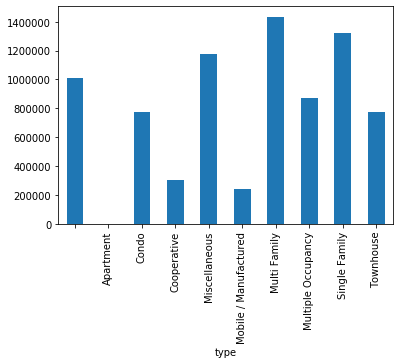

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
data.groupby('type').Zillow.mean().plot.bar()


In [38]:
data.groupby("city").Zillow.mean()

city
LA              6.604078e+05
culver          1.356577e+06
inglewood       7.512054e+05
irvine          1.401144e+06
santa monica    2.451762e+06
Name: Zillow, dtype: float64

In [39]:
data.groupby("city").Zillow.count()

city
LA              758
culver           44
inglewood       143
irvine          518
santa monica    138
Name: Zillow, dtype: int64

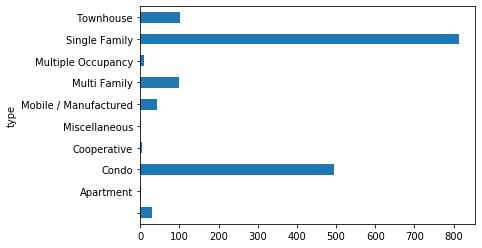

In [40]:
data.groupby('type')["title"].count().plot.barh()

In [41]:
top_10_list_area = (data.area.value_counts(ascending = False).index)[:10]
print(top_10_list_area)

Index(['92618 ', '92612 ', '90302 ', 'Woodland Hills ', 'Sylmar ', '90402 ',
       '90405 ', '90301 ', 'Portola Springs ', 'Northwood '],
      dtype='object')


In [42]:
# selecting rows based on condition 
top_10_df = data[data['area'].isin(top_10_list_area)] 

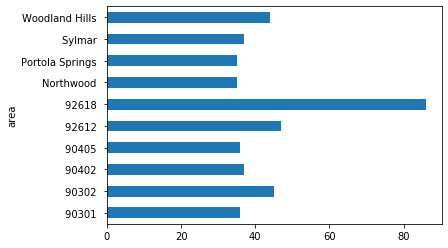

In [43]:
top_10_df.groupby("area")["title"].count().plot.barh()

In [44]:
top_10_g_p = top_10_df.groupby(["area","prediction_combined"]).prediction_rate.max()
top_10_g_p

area              prediction_combined
90301             increase               10.1
90302             increase                2.6
90402             increase                7.3
90405             increase                4.7
92612             decrease                1.6
92618             decrease                0.8
Northwood         increase                0.3
Portola Springs   decrease                0.6
Sylmar            increase                2.2
Woodland Hills    increase                2.0
Name: prediction_rate, dtype: float64

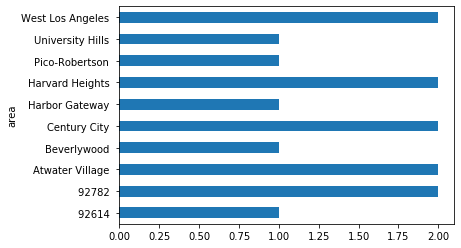

In [45]:
bottom_10_list_area = (data.area.value_counts(ascending = False).index)[-10:]
bottom_10_df = data[data['area'].isin(bottom_10_list_area)]
bottom_10_df.groupby("area")["title"].count().plot.barh()

In [46]:
bottom_10_df.groupby(["area","prediction_combined"]).prediction_rate.max().sort_values(ascending = False)

area               prediction_combined
Beverlywood        increase               9.8
Harvard Heights    increase               7.1
Pico-Robertson     increase               6.3
West Los Angeles   increase               6.0
Century City       increase               5.4
University Hills   increase               4.2
Atwater Village    increase               3.3
Harbor Gateway     increase               2.0
92614              decrease               0.9
92782              increase               0.0
Name: prediction_rate, dtype: float64

In [47]:
increase_df = data[data["prediction_combined"] == "increase"]
avg_increase = increase_df["prediction_rate"].mean()
avg_increase

3.8507601351351437

In [48]:
decrease_df = data[data["prediction_combined"] == "decrease"]
avg_decrease = decrease_df["prediction_rate"].mean()
avg_decrease

0.7655440414507783

In [49]:
decrease_df["area"].unique()

array(['Woodbury ', '92618 ', 'Portola Springs ', 'Woodbridge ',
       'Turtle Rock ', '92602 ', 'West Park ', 'University Park ',
       'Oak Creek ', 'Quail Hill ', '92612 ', 'Turtle Ridge ',
       'University Town Center ', 'Rancho San Joaquin ', 'Irvine ',
       '92614 ', 'Downtown Los Angeles '], dtype=object)

In [50]:
school_df = data[["title", "area","Zillow","school_list"]]

In [51]:
school_df["first_school_grade"] = school_df["school_list"].str[0].str[0]
school_df["first_school"] = school_df["school_list"].str[0].str[1]
school_df["second_school_grade"] = school_df["school_list"].str[1].str[0]
school_df["second_school"] = school_df["school_list"].str[1].str[1]
school_df["third_school_grade"] = school_df["school_list"].str[2].str[0]
school_df["third_school"] = school_df["school_list"].str[2].str[1]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [162]:
school_df.groupby("first_school").agg({'first_school_grade':'max', 'Zillow':'mean'}).sort_values('first_school_grade', ascending = False)

,first_school_grade,Zillow
first_school,,
Encino Charter Elementary School Grades,9,2.979290e+05
Portola Springs Elementary Grades,9,8.865441e+05
Grant Elementary School Grades,9,2.058493e+06
Bonita Canyon Elementary School Grades,9,4.813574e+06
Farragut Elementary School Grades,9,1.802843e+06
...,...,...
Lane (Warren) Elementary School Grades,1,6.574965e+05
Manhattan Place Elementary School Grades,1,6.249040e+05
Yes Academy Grades,1,5.290040e+05


In [163]:
school_df["first_school_grade"].value_counts()

8                                    355
9                                    237
3                                    190
4                                    188
7                                    132
2                                    121
5                                    105
10                                    95
6                                     86
1                                     56
                                      30
 We couldn't find  near this home      6
Name: first_school_grade, dtype: int64